In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd

Loads the rock_paper_scissors dataset from TensorFlow Datasets.

Splits it into 90% training, 10% validation, and 100% of the test set.

Uses as_supervised=True to return data as (image, label) pairs, suitable for training.

Defines a function to resize images to 150x150 and normalize pixel values to the [0, 1] range.

Sets the batch size for training to 32 samples per step.

Applies the preprocessing function to all datasets.

Adds shuffling only to the training set for better generalization.

Batches the datasets and uses prefetch() to optimize performance by overlapping data preprocessing and model execution.

In [3]:
# ========== Load & Split the Dataset ==========
# 90% train, 10% validation, and full test set

train_ds, val_ds, test_ds = tfds.load(
    "rock_paper_scissors",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

# ========== Preprocessing Function ==========
def preprocess(image, label):
    image = tf.image.resize(image, (150, 150))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

# ========== Apply Preprocessing & Batching ==========
train_ds = train_ds.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.D9AYSI_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.D9AYSI_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


## *# This cell defines two model architectures:*

**MLP Model (Multilayer Perceptron):**

Flattens the image into a vector.

Uses two dense layers with ReLU and Dropout for regularization.

Ends with a softmax layer to classify into 3 classes.

**CNN Model (Convolutional Neural Network):**

Starts with convolution + max pooling layers to extract spatial features.

Uses Dropout after each block for regularization.

Ends with dense layers and a softmax output layer for 3-class classification.

In [4]:
# ========== Define MLP & CNN Models ==========
def create_mlp_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model



# This cell defines a dictionary of different optimization algorithms to train the models:

SGD: Stochastic Gradient Descent, a basic optimizer.

SGD with Momentum: Improves vanilla SGD by helping it accelerate in relevant directions.

Adagrad: Adjusts the learning rate based on past gradients, useful for sparse data.

RMSProp: Maintains a moving average of squared gradients, good for non-stationary objectives.

Adam: Combines momentum and adaptive learning rates, usually performs well in most cases.

In [5]:
# ========== Optimizers ==========
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD with Momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'RMSProp': tf.keras.optimizers.RMSprop(),
    'Adam': tf.keras.optimizers.Adam()
}

## *This cell trains both the MLP and CNN models using each of the optimizers defined earlier:*

**For each optimizer in the dictionary:**

It first trains an MLP model:

Compiles the model with the corresponding optimizer.

Trains the model for 10 epochs using the training and validation datasets.

Saves the model and its training history.

Then trains a CNN model similarly and stores the results.

The dictionaries mlp_models, cnn_models, mlp_histories, and cnn_histories store the trained models and their respective histories for future evaluation and plotting.

In [10]:
# ========== Train Models ==========
mlp_models = {}
mlp_histories = {}
cnn_models = {}
cnn_histories = {}

EPOCHS = 10

for name, opt_class in optimizers.items():
    print(f"Training MLP with {name}...")
    mlp_model = create_mlp_model()
    mlp_model.compile(optimizer=opt_class.__class__(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = mlp_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    mlp_models[name] = mlp_model
    mlp_histories[name] = history

    print(f"Training CNN with {name}...")
    cnn_model = create_cnn_model()
    cnn_model.compile(optimizer=opt_class.__class__(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    cnn_models[name] = cnn_model
    cnn_histories[name] = history


Training MLP with SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN with SGD...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP with SGD with Momentum...
Training CNN with SGD with Momentum...
Training MLP with Adagrad...
Training CNN with Adagrad...
Training MLP with RMSProp...
Training CNN with RMSProp...
Training MLP with Adam...
Training CNN with Adam...


# *This cell evaluates the performance of all trained models (both MLP and CNN) on the test dataset:*

It iterates over each trained MLP model:

Evaluates its performance on the test set using model.evaluate.

Stores the loss and accuracy in a dictionary mlp_results.

Prints the evaluation results clearly.

It does the same for each CNN model, storing results in cnn_results.

In [11]:
# ========== Evaluate on Test Set ==========
mlp_results = {}
cnn_results = {}

print("\n=== MLP Test Evaluation ===")
for name, model in mlp_models.items():
    loss, acc = model.evaluate(test_ds, verbose=0)
    mlp_results[name] = {'test_loss': loss, 'test_accuracy': acc}
    print(f"{name}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

print("\n=== CNN Test Evaluation ===")
for name, model in cnn_models.items():
    loss, acc = model.evaluate(test_ds, verbose=0)
    cnn_results[name] = {'test_loss': loss, 'test_accuracy': acc}
    print(f"{name}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


=== MLP Test Evaluation ===
SGD: Loss = 1.0988, Accuracy = 0.3145
SGD with Momentum: Loss = 1.0985, Accuracy = 0.4086
Adagrad: Loss = 1.0986, Accuracy = 0.3414
RMSProp: Loss = 1.0986, Accuracy = 0.3333
Adam: Loss = 1.0986, Accuracy = 0.3360

=== CNN Test Evaluation ===
SGD: Loss = 0.8460, Accuracy = 0.5296
SGD with Momentum: Loss = 0.6294, Accuracy = 0.7527
Adagrad: Loss = 1.0180, Accuracy = 0.4624
RMSProp: Loss = 1.3266, Accuracy = 0.7392
Adam: Loss = 1.5845, Accuracy = 0.7769


# *This part of the code visualizes the training progress of both MLP and CNN models using line plots:*

📊 plot_history Function:
Takes training histories, test results, a specific metric (like "loss" or "accuracy"), and a title.

It loops through each model's training history and plots the chosen metric over epochs.

Each line in the plot includes the optimizer name and its final test accuracy, which helps compare optimizers visually.

The function supports plotting both training and validation curves.

📈 Plots Generated:
MLP Plots: Shows how training and validation loss and accuracy evolved over epochs.

CNN Plots: Same plots but for CNN models.

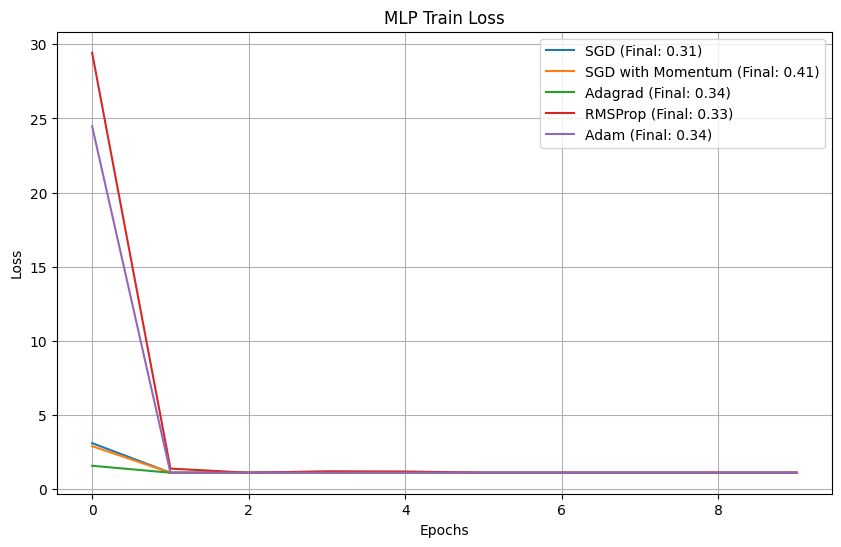

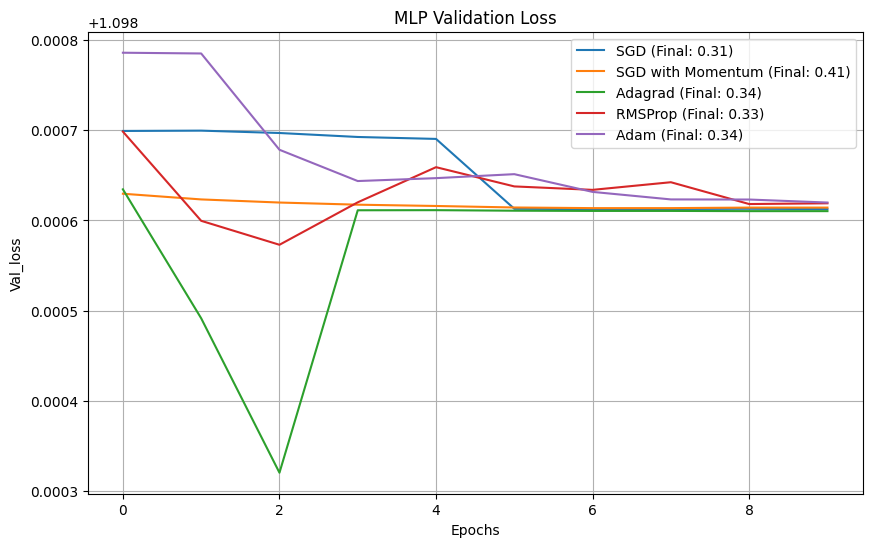

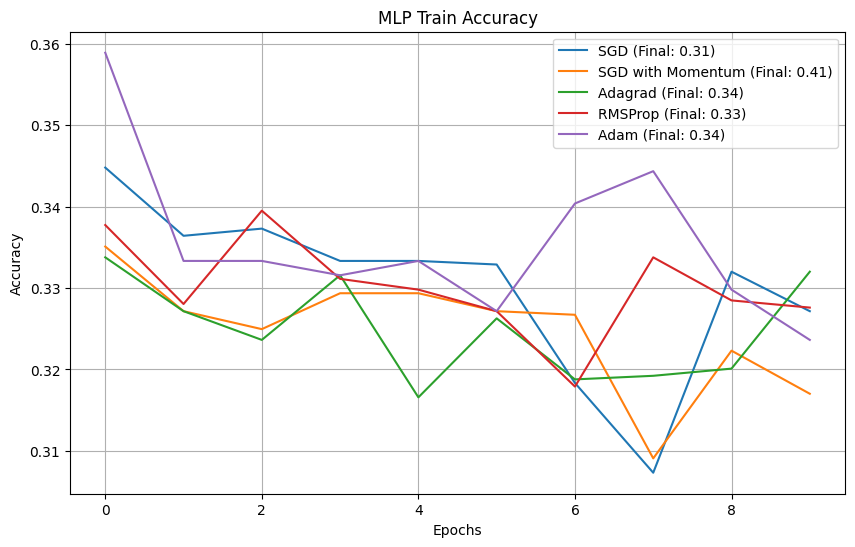

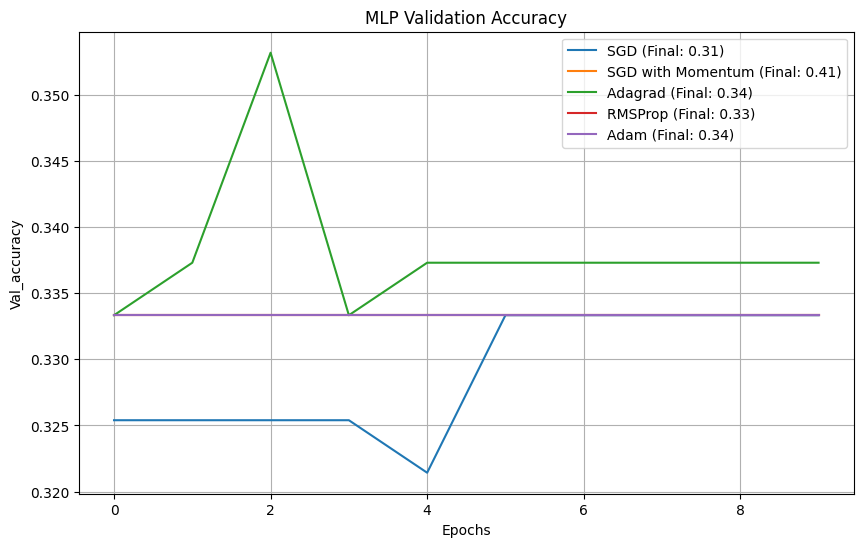

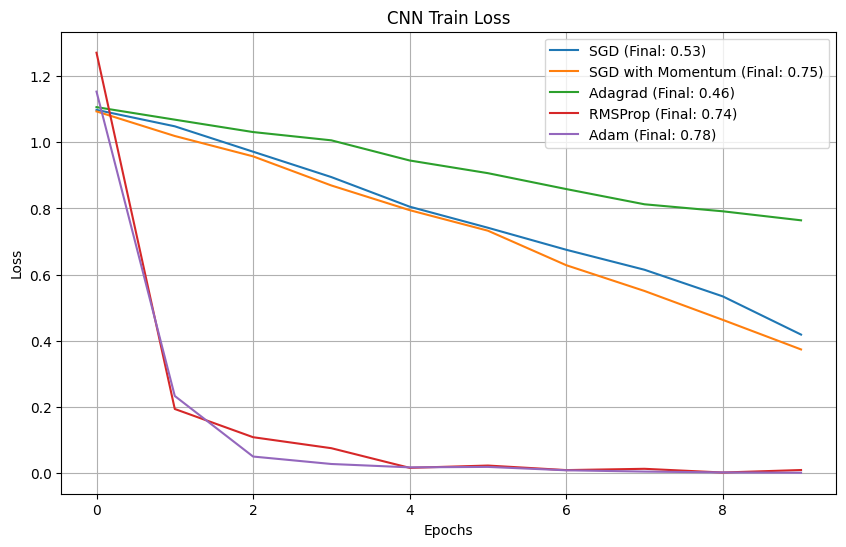

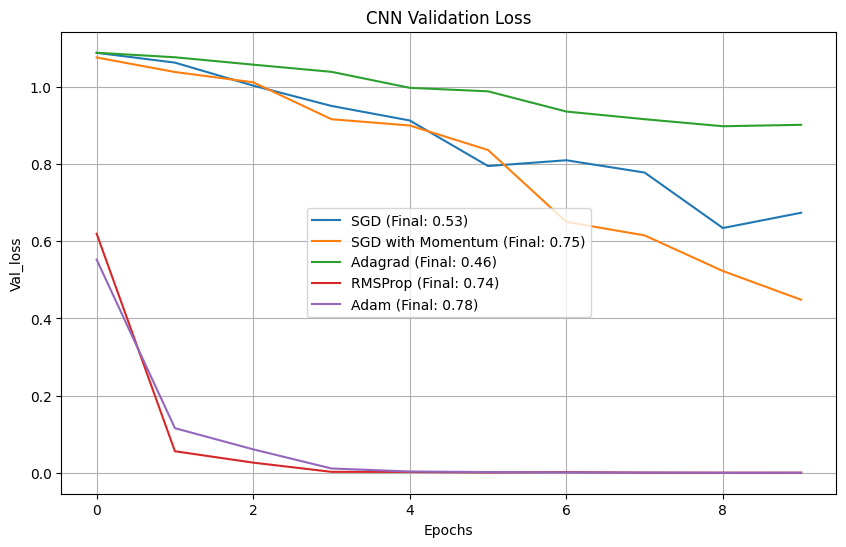

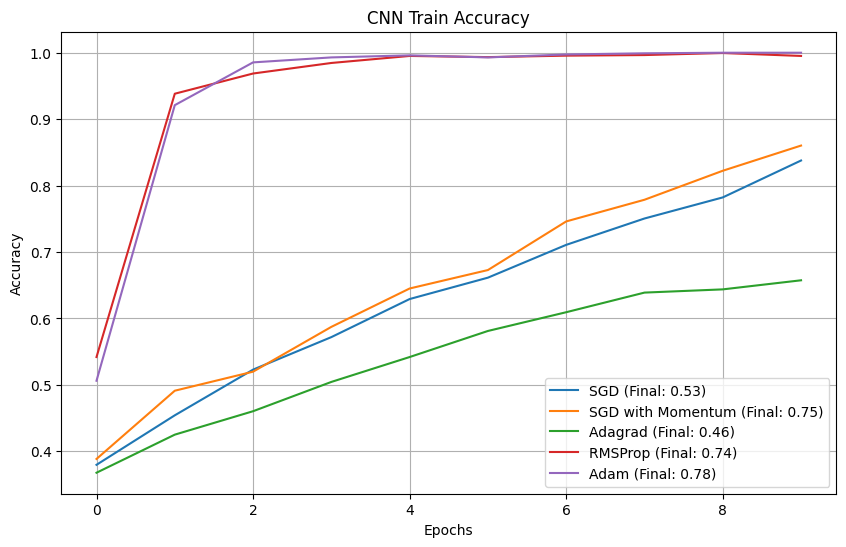

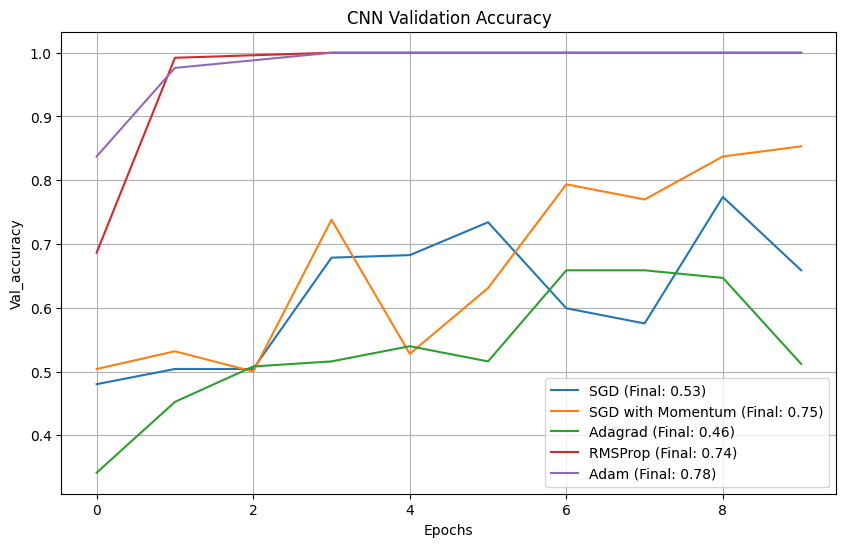

In [12]:
# ========== Plotting Function ==========
def plot_history(histories, results, metric, title):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f"{name} (Final: {results[name]['test_accuracy']:.2f})")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# ========== MLP Plots ==========
plot_history(mlp_histories, mlp_results, 'loss', "MLP Train Loss")
plot_history(mlp_histories, mlp_results, 'val_loss', "MLP Validation Loss")
plot_history(mlp_histories, mlp_results, 'accuracy', "MLP Train Accuracy")
plot_history(mlp_histories, mlp_results, 'val_accuracy', "MLP Validation Accuracy")

# ========== CNN Plots ==========
plot_history(cnn_histories, cnn_results, 'loss', "CNN Train Loss")
plot_history(cnn_histories, cnn_results, 'val_loss', "CNN Validation Loss")
plot_history(cnn_histories, cnn_results, 'accuracy', "CNN Train Accuracy")
plot_history(cnn_histories, cnn_results, 'val_accuracy', "CNN Validation Accuracy")



# *✅ extract_final_metrics_and_test Function:*
Takes in:

The model dictionary (mlp_models or cnn_models)

The training histories (mlp_histories or cnn_histories)

The test dataset (test_ds)

For each model:

Extracts the last values of training and validation loss and accuracy.

Evaluates the model on the test set to get test loss and test accuracy.

Stores all of these in a nicely formatted dictionary.

📊 Creating Result Tables:
Calls the function for both MLP and CNN models to generate:

mlp_results: contains results for MLP models

cnn_results: contains results for CNN models

Converts the results into pandas DataFrames (mlp_df and cnn_df) for easy viewing.

🖥️ Display Settings:
Expands pandas' display settings so all rows and columns are fully visible in the output.

📋 Prints the Results:
Neatly prints out summary tables of final training, validation, and test metrics for each optimizer used.

In [13]:
import pandas as pd

# ========== Auto Extract Final Metrics & Test Results ========== #
def extract_final_metrics_and_test(models_dict, histories_dict, test_ds):
    results = {}
    for name in histories_dict:
        hist = histories_dict[name].history
        model = models_dict[name]

        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

        results[name] = {
            'Train Loss': round(hist['loss'][-1], 4),
            'Train Accuracy': round(hist.get('accuracy', hist.get('acc', [0]))[-1], 4),
            'Validation Loss': round(hist['val_loss'][-1], 4),
            'Validation Accuracy': round(hist.get('val_accuracy', hist.get('val_acc', [0]))[-1], 4),
            'Test Loss': round(test_loss, 4),
            'Test Accuracy': round(test_accuracy, 4)
        }
    return results

# ========== Extract All Results ========== #
mlp_results = extract_final_metrics_and_test(mlp_models, mlp_histories, test_ds)
cnn_results = extract_final_metrics_and_test(cnn_models, cnn_histories, test_ds)

# ========== Set Display Options ========== #
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# ========== Create and Show Summary Tables ========== #
mlp_df = pd.DataFrame.from_dict(mlp_results, orient='index')
cnn_df = pd.DataFrame.from_dict(cnn_results, orient='index')

print("\n=== MLP Results Table ===")
print(mlp_df.to_string(index=True))

print("\n=== CNN Results Table ===")
print(cnn_df.to_string(index=True))



=== MLP Results Table ===
                   Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  Test Loss  Test Accuracy
SGD                    1.0987          0.3272           1.0986               0.3333     1.0988         0.3145
SGD with Momentum      1.0987          0.3170           1.0986               0.3333     1.0985         0.4086
Adagrad                1.0986          0.3320           1.0986               0.3373     1.0986         0.3414
RMSProp                1.0987          0.3276           1.0986               0.3333     1.0986         0.3333
Adam                   1.0988          0.3236           1.0986               0.3333     1.0986         0.3360

=== CNN Results Table ===
                   Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  Test Loss  Test Accuracy
SGD                    0.4186          0.8377           0.6740               0.6587     0.8460         0.5296
SGD with Momentum      0.3737          0.8602           0.4484    